# Generating maze with rewards and agent

Defining maze environment with objects, such as obstacles, agent and reward.

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra

from mazelab import VonNeumannMotion
from mazelab import MooreMotion

In [30]:
## in ASCII \# for walls and \. for a possible way

## in numpy array \1 for walls and \0 for a possible way

f = open('2.txt', 'r')
maze_txt = f.read()
print(maze_txt)

#####################
#...................#
#...#...#...#...#####
#...#...#...#.......#
#...#########...#####
#...........#.......#
#...#####...#...#####
#.......#...#.......#
#...#####...#########
#.......#...........#
#####################


In [31]:
maze_lst = []
for i in maze_txt:
    if i == "#":
        maze_lst.append(1)
    elif i == ".":
        maze_lst.append(0)
    else:
        continue
print(len(maze_lst))

maze = np.array(maze_lst)
maze = maze.reshape(11,21)
maze

231


array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

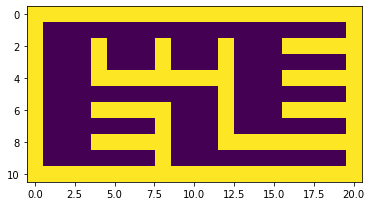

In [32]:
start_idx = [[1,18]]
goal_idx = [[9, 7]]

plt.imshow(maze)

env_id = 'MazeRoom-v1'

In [33]:
# Four room task
#x = np.array([np.ones(19),
#              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
#              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
#              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
#              np.concatenate([[1], np.zeros(8), [0], np.zeros(8), [1]]),
#              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),                                    
#              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
#              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
#              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
#              np.concatenate([np.ones(4), [0],  np.ones(9), [0], np.ones(4)]),
#              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
#              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
#              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
#              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
#              np.concatenate([[1], np.zeros(8), [0], np.zeros(8), [1]]),
#              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
#              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
#              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
#              np.ones(19)])

#start_idx = [[4, 4]] 
#goal_idx = [[14, 14]] 
#env_id = 'FourRoom-v0'

#plt.imshow(x)

In [34]:
import numpy as np
from mazelab import BaseMaze
from mazelab import Object
from mazelab import DeepMindColor as color


class Maze(BaseMaze):
    @property
    def size(self):
        return maze.shape
    
    def make_objects(self):
        free = Object('free', 0, color.free, False, np.stack(np.where(maze == 0), axis=1))
        obstacle = Object('obstacle', 1, color.obstacle, True, np.stack(np.where(maze == 1), axis=1))
        agent = Object('agent', 2, color.agent, False, [])
        goal = Object('goal', 3, color.goal, False, [])
        return free, obstacle, agent, goal

In [35]:
from mazelab import BaseEnv
from mazelab import VonNeumannMotion
import gym
from gym.spaces import Box
from gym.spaces import Discrete


class Env(BaseEnv):
    def __init__(self):
        super().__init__()
        
        self.maze = Maze()
        self.motions = VonNeumannMotion()
        
        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))
        
    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        if valid:
            self.maze.objects.agent.positions = [new_position]
        
        if self._is_goal(new_position):
            reward = +1
            done = True
        elif not valid:
            reward = -1
            done = False
        else:
            reward = -0.01
            done = False
        return self.maze.to_value(), reward, done, {}
        
    def reset(self):
        self.maze.objects.agent.positions = start_idx
        self.maze.objects.goal.positions = goal_idx
        return self.maze.to_value()
    
    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable
    
    def _is_goal(self, position):
        out = False
        for pos in self.maze.objects.goal.positions:
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out
    
    def get_image(self):
        return self.maze.to_rgb()

In [36]:
from gym.envs.registration import register


gym.envs.register(
     id=env_id,
     entry_point=Env,
     max_episode_steps=20,
)

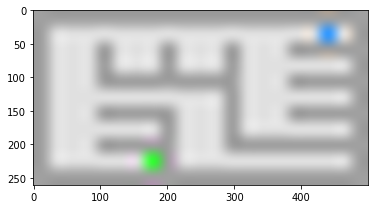

In [37]:
env = gym.make(env_id)
env.reset()
img = env.render('rgb_array')
plt.imshow(img)

# Finding the shortest way

[Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) is an algorithm for finding the shortest path between nodes in a graph, producing shortest-path tree.

In [38]:
from mazelab.solvers import dijkstra_solver

# https://github.com/zuoxingdong/mazelab/blob/master/mazelab/solvers/dijkstra_solver.py

impassable_array = env.unwrapped.maze.to_impassable()
motions = env.unwrapped.motions
start = env.unwrapped.maze.objects.agent.positions[0]
goal = env.unwrapped.maze.objects.goal.positions[0]
actions = dijkstra_solver(impassable_array, motions, start, goal)
print(actions)

env = gym.wrappers.Monitor(env, './', force=True)
rewards = 0.0
env.reset()

for action in actions:
    _, reward, _, _ = env.step(action)
    rewards += reward    
env.close()

print(rewards)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3]


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: './openaigym.video.0.16772.video000000.mp4'

In [20]:
import imageio
from IPython.display import Image
from pathlib import Path
f = list(Path('./').glob('*.mp4'))[0]
reader = imageio.get_reader(f)
f = f'./{env_id}.gif'
with imageio.get_writer(f, fps=3) as writer:
    [writer.append_data(img) for img in reader]
Image(f)

IndexError: list index out of range

# Transforming maze into a graph

Goal of this phase is to create proper graph representation of an environment using [NetworkX](https://networkx.org/documentation/stable/tutorial.html).

In [18]:
import networkx as nx
import pylab as plt

G = nx.DiGraph()
#go node by node and check if his neighbour is available 


In [25]:
for idx in range(len(maze.flatten())):
    if maze.flatten()[idx]==0:
        G.add_node(idx)
        
G.number_of_nodes()

32